Note: *It may take a minute for the structures to render, please be patient.*

In [1]:
# This notebook shows logo plots and interactive structure widgets.
# It is set up so that it can be parameterized by papermill.
# It is designed so that it can be run in appmode
# (https://github.com/oschuett/appmode), and for that reason has
# comments written mostly in code cells rather than Markdown.

In [2]:
# import Python modules

import io
import os

from IPython.display import display, Image

import matplotlib.image
import matplotlib.pyplot as plt

import nglview

import pandas as pd

import yaml

from dmslogo import facet_plot
from dms_struct.colorschemes import ValueToColorMap
from dms_struct.struct_widget import colored_struct

In [3]:
# This cell is tagged `parameters` to enable papermill parameterization
# See: https://papermill.readthedocs.io/en/latest/usage-parameterize.html
# Parameters set to `None` MUST be parameterized.

data_csv = None  # CSV file with tiday data frame to plot
query_str = None  # query data frame using this str to get just subset to plot
mut_metric = 'mutdiffsel'  # mutation-level selection metric
site_metric = 'positive_diffsel'  # site-level selection metric
facet_col = None  # column specifying each subset to plot, for instance serum or antibody
isite_col = 'isite'  # column specifying sites in sequential integer numbering
site_col = 'site'  # column specifying site number as str
pdb_chain_col = 'pdb_chain'  # column specifying PDB chain
pdb_site_col = 'pdb_site'  # column specifying PDB site
zoom_col = 'zoom_site'  # column indicating sites to zoom in logo and struct
wildtype_col = 'wildtype'  # column indicating wildtype identity at site
mutation_col = 'mutation'  # column indicating amino-acid mutant

# representation for structure, such as `cartoon`, `surface`, `spacefill`
representation = ['surface', 'spacefill']

outdir = None  # output directory for structure images

pdb = None  # PDB ID
# orientation of structure: https://github.com/arose/nglview/issues/785#issuecomment-487409212
orientation = [113.5, 44.09, 180.08, 0, -185.38, 23.99, 110.97, 0,
               2.63, -211.51, 50.12, 0, -34.66, 25.44, 46.9, 1]

# specs for panel of structure images created as image file
panel_height = None  # height of panel plot
panel_top = 0.9  # top margin of panel
panel_wspace = 0.4  # space between subplots
panel_legend_width = 0.3  # width of legend relative to subplots
panel_fig = None  # created panel imaged file

# Do structures and logo plots have separate scales for immune selection coloring?
separatescale = True

In [4]:
# Parameters
data_csv = "../avgdiffsel/avg_sel_tidy.csv"
query_str = "serum_name_formatted in ['2010-age-21', '2009-age-53', '2009-age-64', '2009-age-65']"
facet_col = "serum_name_formatted"
pdb = "4o5n"
outdir = "../structs"
panel_fig = "../figures/VIDD_sera_struct.png"
panel_height = 4


Scale bar mapping the strength of immune selection to the colors in the structure and logo plots:

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Immune selection color-scale is different for each structure:


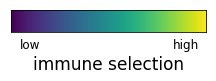

In [5]:
# read the data
data = pd.read_csv(data_csv)

# query data if applicable
if query_str:
    data = data.query(query_str)

# get mutation-level data for logo plot plotting
mut_df = (data
          [[facet_col, isite_col, site_col, pdb_chain_col, pdb_site_col,
            zoom_col, wildtype_col, mutation_col, mut_metric, site_metric]]
          .assign(**{site_col: lambda x: x[site_col].astype('str')})
          .assign(site_label=lambda x: x[wildtype_col] + x[site_col],
                  facet_spaces=lambda x: x[facet_col].str.replace('-', ' '))
          )

if separatescale:
    print('Immune selection color-scale is different for each structure:')
    mut_df_list = []
    for facet, facet_df in mut_df.groupby(facet_col, sort=False):
        colormapper = ValueToColorMap(0, facet_df[site_metric].max())
        mut_df_list.append(facet_df.assign(color=lambda x: (x[site_metric]
                                               .apply(colormapper.val_to_color))))
    mut_df = pd.concat(mut_df_list)
else:
    print("Immune selection color-scale is shared across structures:")
    colormapper = ValueToColorMap(0, mut_df[site_metric].max())
    mut_df = mut_df.assign(color=lambda x: (x[site_metric]
                                           .apply(colormapper.val_to_color)))

# get site level data for structure images
site_df = (mut_df
           [[facet_col, pdb_chain_col, pdb_site_col, zoom_col, 'color']]
           .drop_duplicates()
           )

# show the scale bar
fig, _ = colormapper.scale_bar(label='immune selection',
                               orientation='horizontal',
                               low_high_ticks_only=separatescale)
display(fig)
plt.close(fig)

In [6]:
%%capture
# `%%capture` prevents plots from being shown

# get logo plots for each facet
logoplots = {}
for facet, facet_df in mut_df.groupby(facet_col, sort=False):
    if separatescale:
        ymax = facet_df[site_metric].max()
    else:
        ymax = mut_df[site_metric].max()   
    assert ymax > 0
    dy = 0.055 * ymax  # extra for y-limits
    fig, _ = facet_plot(facet_df,
                        gridrow_col='facet_spaces',
                        x_col=isite_col,
                        show_col=zoom_col,
                        draw_line_kwargs={'height_col': site_metric,
                                          'xtick_col': site_col,
                                          'ylabel': 'immune selection'},
                        draw_logo_kwargs={'letter_col': mutation_col,
                                          'letter_height_col': mut_metric,
                                          'xtick_col': 'site_label',
                                          'color_col': 'color',
                                          'xlabel': site_col,
                                          'ylabel': 'immune selection',
                                          'clip_negative_heights': True},
                        line_titlesuffix='site-level selection',
                        logo_titlesuffix='mutation-level selection',
                        share_ylim_across_rows=False,
                        share_xlabel=True,
                        share_ylabel=True,
                        height_per_ax=2,
                        set_ylims=(-dy, ymax + dy)
                        )
    logoplots[facet] = fig

In [7]:
# get structure widgets for each facet
widgets = {}
for facet, facet_df in site_df.groupby(facet_col, sort=False):
    w = colored_struct(pdb=pdb,
                       prop_df=facet_df,
                       chain_col=pdb_chain_col,
                       site_col=pdb_site_col,
                       representation=representation,
                       highlight_col=zoom_col,
                       orientation=orientation,
                       )
    widgets[facet] = w

Maps of immune selection:
 - The line plots show the total selection at each site.
 - The logo plots show selection for each mutation at key sites.
 - The structures show the selection at each site.

------------------------ 2010 age 21 ------------------------


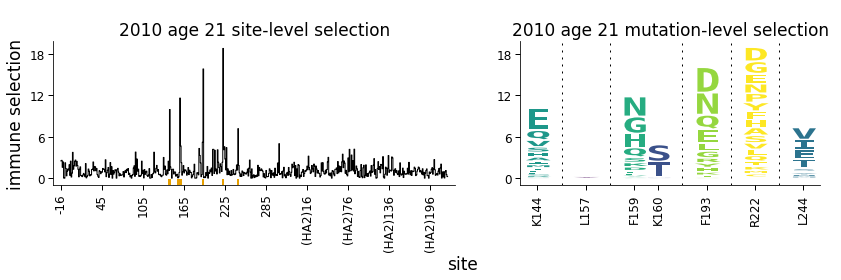

NGLWidget()

------------------------ 2009 age 53 ------------------------


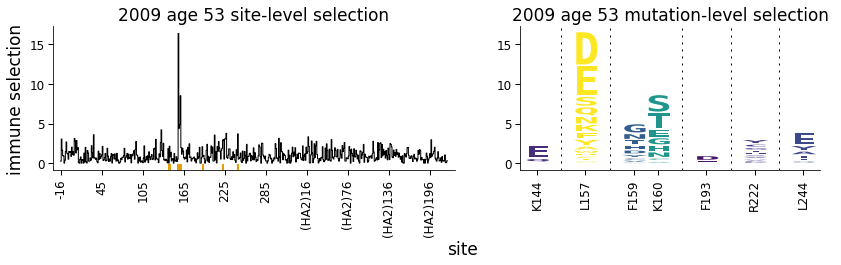

NGLWidget()

------------------------ 2009 age 64 ------------------------


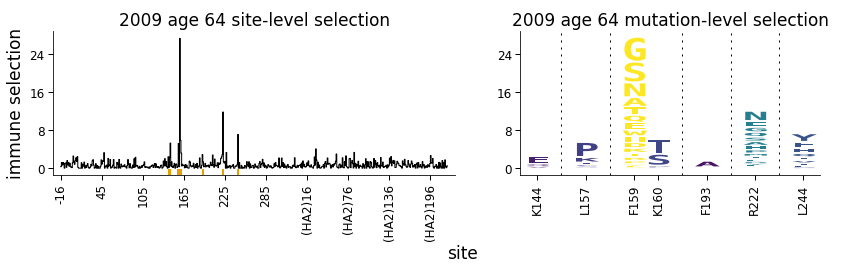

NGLWidget()

------------------------ 2009 age 65 ------------------------


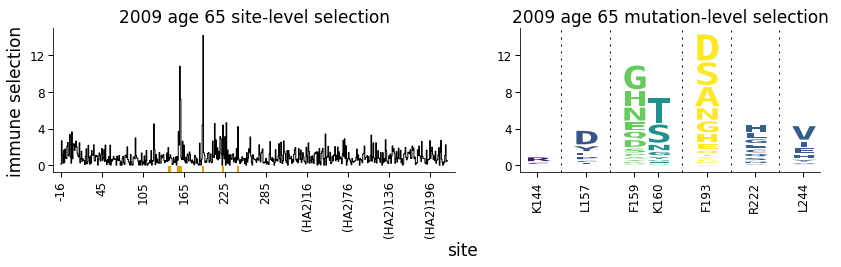

NGLWidget()

In [8]:
# show logo plots and widgets
for facet, logofig in logoplots.items():
    print('-' * 24 + f" {facet.replace('-', ' ')} " + '-' * 24)
    display(logofig)
    display(widgets[facet])

In [9]:
images = {}
for facet, w in widgets.items():
    images[facet] = w.render_image(factor=4, trim=True)

In [10]:
# YOU MUST WAIT FOR THE IMAGES ABOVE TO RENDER BEFORE RUNNING THE FOLLOWING CELLS

In [11]:
os.makedirs(outdir, exist_ok=True)
png_files = {}
for facet, image in images.items():
    png_file = os.path.join(outdir, f"{facet}.png")
    with open(png_file, 'wb') as f:
        if image:
            f.write(image.value)
    png_files[facet] = png_file

In [12]:
# Show all structures in a panel.
# Follow basic idea here to show PNGs as matplotlib plot:
# https://stackoverflow.com/a/50569248

mpimages = {}
for facet, png in png_files.items():
    with open(png, 'rb') as f:
        contents = f.read()
    if contents:
        mpimages[facet] = matplotlib.image.imread(png)
    else:
        dummyfig = plt.figure(figsize=(panel_height, panel_height))
        plt.xticks([], fig=dummyfig)
        plt.yticks([], fig=dummyfig)
        plt.text(0.5, 0.5,
                 f"Empty PNG for {facet}.\n"
                 'Did you allow widgets to render\n'
                 'before running subsequent cells?',
                 va='center', ha='center')
        with io.BytesIO() as f:
            dummyfig.savefig(f, format='png')
            f.seek(0)
            mpimages[facet] = matplotlib.image.imread(f)
        plt.close(dummyfig)

aspects = [img.shape[1] / img.shape[0] for img in mpimages.values()]
aspects.insert(0, sum(aspects) / len(aspects) * panel_legend_width * 0.5)
nax = len(aspects)
figwidth = panel_height * sum(aspects) * (1 + panel_wspace)
avgpanelwidth = sum(aspects) / len(aspects) * panel_height

fig, axes = plt.subplots(
                nrows=1,
                ncols=nax,
                figsize=(figwidth, panel_height),
                gridspec_kw={'width_ratios': aspects},
                )

fig.subplots_adjust(left=0.5 * panel_legend_width / sum(aspects),
                    right=1 - panel_wspace * avgpanelwidth / figwidth,
                    bottom=0.03, top=panel_top,
                    wspace=panel_wspace, hspace=0)

_ = colormapper.scale_bar(label='immune selection',
                          orientation='vertical',
                          ax=axes[0],
                          low_high_ticks_only=separatescale)

for ax, (title, img) in zip(axes[1 : ], mpimages.items()):
    ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title.replace('-', ' '),
                     fontsize=17,
                     verticalalignment='bottom',
                     )

os.makedirs(os.path.dirname(panel_fig), exist_ok=True)
fig.savefig(panel_fig, dpi=400)
        
plt.close(fig)

In [13]:
# to look at the PNG of the panel of images, uncomment the line below
# display(Image(panel_fig))